In [43]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [46]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [47]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/kx/16xjkcl54kg7d7_x28nq39s00000gn/T/ipykernel_34562/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [48]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [49]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [50]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [52]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


<Figure size 1000x600 with 0 Axes>

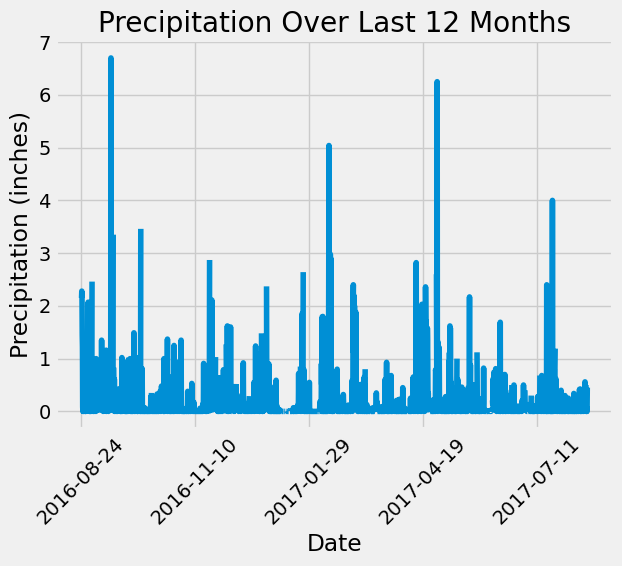

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")

# Set the index to the date column for better plotting
precipitation_df.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
precipitation_df.plot(title="Precipitation Over Last 12 Months", legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.show()

In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df["Precipitation"].describe()
print(precipitation_summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [55]:
from sqlalchemy import func
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [56]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

# Display the stations and their counts
for station, count in most_active_stations:
    print(f"Station: {station}, Observations: {count}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [58]:
most_active_station = most_active_stations[0][0]

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station: {most_active_station}")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


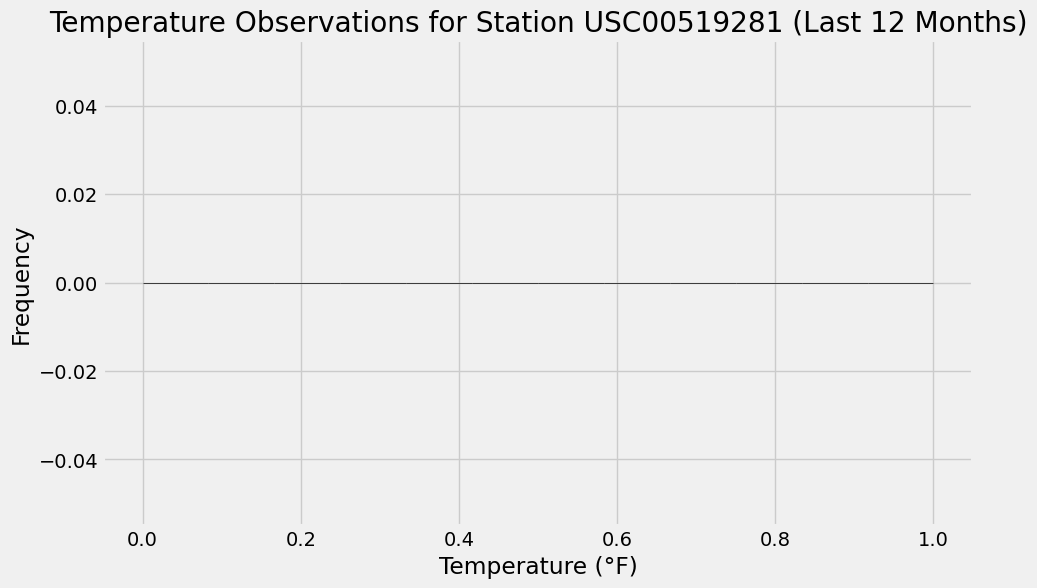

In [63]:
# Using the most active station id
most_active_station = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    all()

# Convert the data into a list of temperature values
temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10,6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [62]:
# Close Session
session.close()